ttim_examples

In [2]:
"""
ttim has two aquifer systems, one with aquifers and aquitards `ModelMaq` and one with only layers in a 3d system `Model3D`.

For the `ModelMaq` system one specifies:

ttim.ModelMaq(
    kaq: Any = 1, z: Any = [1, 0],
    c: Any = [],
    Saq: Any = [0.001],
    Sll: Any = [0], poraq: Any = [0.3],
    porll: Any = [0.3],
    topboundary: str = 'conf',
    phreatictop: bool = False,
    tmin: int = 1,
    tmax: int = 10,
    tstart: int = 0,
    M: int = 10,
    timmlmodel: Any | None = None) -> None

    z : array or list
        elevation of tops and bottoms of the aquifers from the top down (leaky layers may have zero thickness)
        if top='conf': length is 2 * number of aquifers
        if top='semi': length is 2 * number of aquifers + 1 as top of leaky layer on top of systems needs to be specified

For the Model3D system one specifies:

ttim.ModelM3d(
    kaq: int = 1,
    z: Any = [4, 3, 2, 1],
    Saq: float = 0.001,
    kzoverkh: float = 0.1,
    poraq: float = 0.3,
    topboundary: str = 'conf',
    phreatictop: bool = False,
    topres: int = 0,
    topthick: int = 0,
    topSll: int = 0,
    toppor: float = 0.3,
    tmin: int = 1,
    tmax: int = 10,
    tstart: int = 0,
    M: int = 10,
    timmlmodel: Any | None = None) -> None

z must have the length of the number of layers + 1

""" 

"\nttim has two aquifer systems, one with aquifers and aquitards `ModelMaq` and one with only layers in a 3d system `Model3D`.\n\nFor the `ModelMaq` system one specifies:\n\nttim.ModelMaq(\n    kaq: Any = 1, z: Any = [1, 0],\n    c: Any = [],\n    Saq: Any = [0.001],\n    Sll: Any = [0], poraq: Any = [0.3],\n    porll: Any = [0.3],\n    topboundary: str = 'conf',\n    phreatictop: bool = False,\n    tmin: int = 1,\n    tmax: int = 10,\n    tstart: int = 0,\n    M: int = 10,\n    timmlmodel: Any | None = None) -> None\n\n    z : array or list\n        elevation of tops and bottoms of the aquifers from the top down (leaky layers may have zero thickness)\n        if top='conf': length is 2 * number of aquifers\n        if top='semi': length is 2 * number of aquifers + 1 as top of leaky layer on top of systems needs to be specified\n\nFor the Model3D system one specifies:\n\nttim.ModelM3d(\n    kaq: int = 1,\n    z: Any = [4, 3, 2, 1],\n    Saq: float = 0.001,\n    kzoverkh: float = 0.1,\n

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ttim

In [4]:
from scipy.special import exp1

def theis(r, t, kD, S, Q):
    """Return head changeaccording to Theis for extraction Q.
    
    Parameters
    ----------
    Q: float
        extraction (positive Q causes negative head change)
    
    """
    u = r ** 2 * S / (4 * kD * t)
    h = -Q / (4 * np.pi * kD) * exp1(u)
    return h

def theisQr(r, t, kD, S, Q):
    """Return total flow at distance r and time t.
    
    Parameters
    ----------
    Q: float
        extraction (positive Q causes negative drawdown)
    
    """
    u = r ** 2 * S / (4 * kD * t)
    return -Q / (2 * np.pi) * np.exp(-u) / r

In [5]:
kD = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
r = 30.
Q = 788

In [6]:
htheis = theis(r, t, kD, S, Q)
Qrtheis = theisQr(r, t, kD, S, Q)

In [7]:
ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = ttim.Well(ml, tsandQ=[(0, Q)], rw=1e-5)
ml.solve()
h = ml.head(r, 0, t)
Qx, Qy = ml.disvec(r, 0, t)

self.neq  1
solution complete


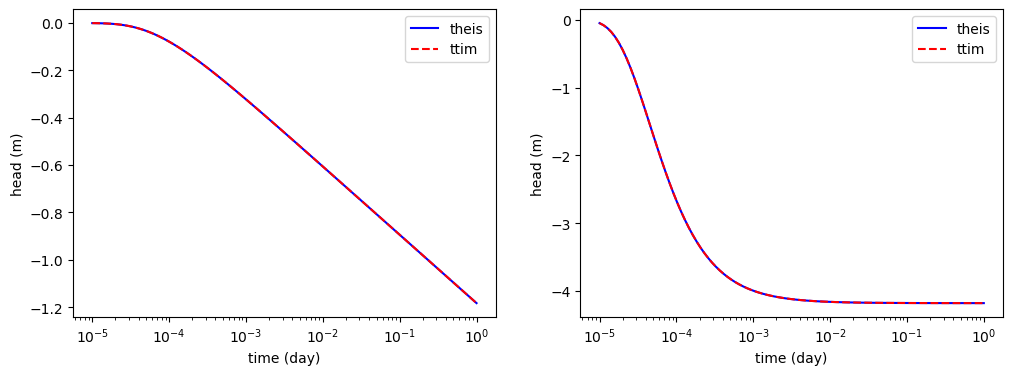

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.semilogx(t, htheis, 'b', label='theis')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.xlabel('time (day)')
plt.ylabel('head (m)')
plt.legend()
plt.subplot(122)
plt.semilogx(t, Qrtheis, 'b', label='theis')
plt.semilogx(t, Qx[0], 'r--', label='ttim')
plt.xlabel('time (day)')
plt.ylabel('head (m)')
plt.legend(loc='best');

Hantush

In [9]:
kD = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
r = 30.
c = 1000.
Q = 788

In [10]:
from scipy.integrate import quad
def integrad_hantush(y, r, lab):
    return np.exp(-y - r ** 2 / (4 * lab ** 2 * y)) / y

def hantush(r, t, kD, S, c, Q, tstart=0):
    lab = np.sqrt(kD * c)
    u = r ** 2 * S / (4 * kD * (t - tstart))
    F = quad(integrad_hantush, u, np.inf, args=(r, lab))[0]
    return -Q / (4 * np.pi * kD) * F

hantushvec = np.vectorize(hantush)

In [11]:
ml = ttim.ModelMaq(kaq=25, z=[21, 20, 0], c=[1000], Saq=S/20, topboundary='semi', tmin=1e-5, tmax=1)
w = ttim.Well(ml, tsandQ=[(0, Q)])
ml.solve()

self.neq  1
solution complete


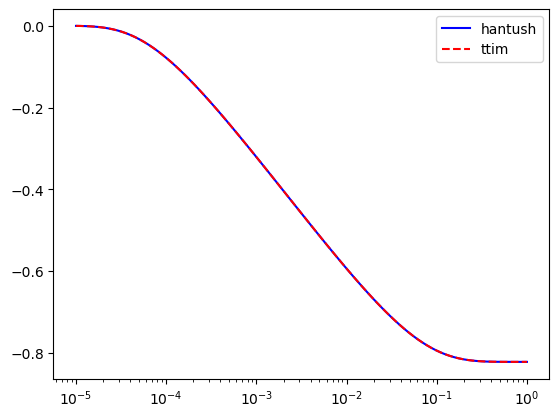

In [12]:
hhantush = hantushvec(30, t, kD, S, c, Q)
h = ml.head(r, 0, t)
plt.semilogx(t, hhantush, 'b', label='hantush')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.legend(loc='best')

Well with wellbore storage

self.neq  1
solution complete
self.neq  1
solution complete


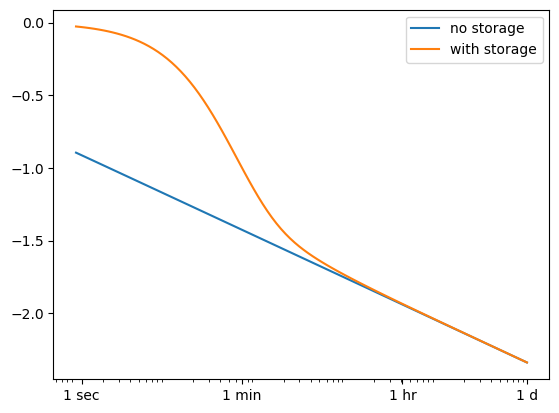

In [13]:
kD = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
rw = 0.3
Q = 788

ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = ttim.Well(ml, rw=rw, tsandQ=[(0, Q)])
ml.solve()
hnostorage = ml.head(rw, 0, t)

ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = ttim.Well(ml, rw=rw, tsandQ=[(0, Q)], rc=rw)
ml.solve()
hstorage = ml.head(rw, 0, t)

plt.semilogx(t, hnostorage[0], label='no storage')
plt.semilogx(t, hstorage[0], label='with storage')
plt.legend(loc='best')
plt.xticks([1/(24*60*60), 1/(24 * 60), 1/24, 1], ['1 sec', '1 min', '1 hr', '1 d']);

Head Well

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.neq  1
solution complete
self.neq  1
solution complete


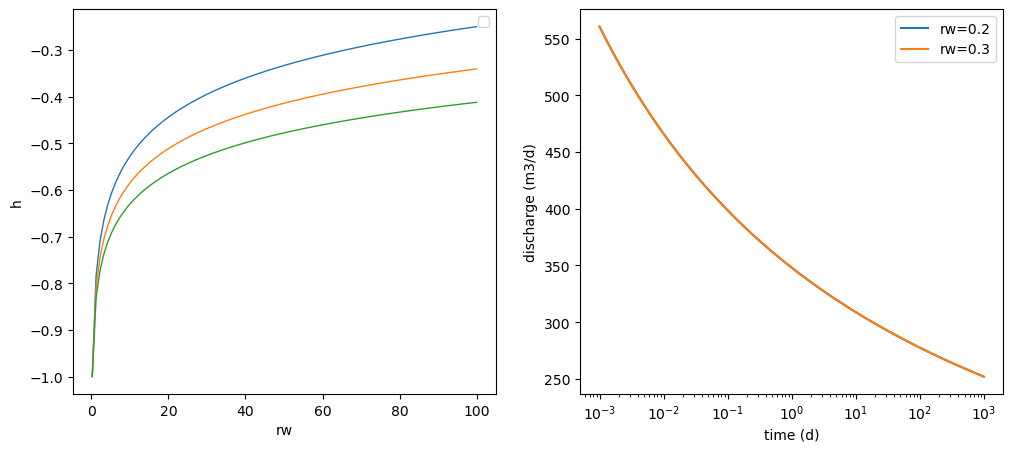

In [14]:
# First model with head well with given radius rw
ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=1e-5, tmin=1e-3, tmax=1000)
w = ttim.HeadWell(ml, tsandh=[(0, -1)], rw=0.2)
ml.solve()
plt.figure(figsize=(12,5))

# First picture is a cross section for three times:
plt.subplot(1,2,1)
ml.xsection(0.2, 100, 0, 0, 100, t=[0.1, 1, 10], sstart=0.2, newfig=False)
plt.xlabel('rw')
plt.ylabel('h')
plt.legend()

# Compute the well discharge for many times:
t = np.logspace(-3, 3, 100)
dis = w.discharge(t)

# Another model with a new wel with different radius rw
ml = ttim.ModelMaq(kaq=25, z=[20, 0], Saq=1e-5, tmin=1e-3, tmax=1000)
w = ttim.HeadWell(ml, tsandh=[(0, -1)], rw=0.3)
ml.solve()
dis = w.discharge(t)

# Plot the discharge for the two wells (different rw) for many times
plt.subplot(1,2,2)
plt.semilogx(t, dis[0], label='rw=0.2')
plt.semilogx(t, dis[0], label='rw=0.3')
plt.xlabel('time (d)')
plt.ylabel('discharge (m3/d)')
plt.legend()

plt.show()

In [33]:
def ttimz(z0=0., d=[9, 5], D=[10, 20, 30]):
    """Return top and bottof of aquifers including top aquitard if topclosed==False.
    
    Parameters
    ----------
    z0: float, optional
        top elevation of the layer system
    d: sequence of floats
        thicknesses of the aquitards (zeros allowed)
    D: sequence of floats
        thicknesses of the aquifers (zeros not allowed)
    
    Returns
    -------
    vector of the tops and bottoms of the aquifers.
    In case len(d) == len(D) - 1, the top is confined (topclosed=True)
    In case len(d) == len(D) the top is semi-confined. The top d is then
    the thickness of the top aquitard.
    """
    assert np.isscalar(z0), 'z0 (top of model elevation) must be a scalar.'
    assert len(d) == len(D) or len(d) == len(D) - 1,\
        'len(d) must be len(D)-1 if topclosed or len(D) if not.'
    
    topclosed = len(d) < len(D)
    if topclosed:    
        d = [0.] + d
    z = z0 - np.hstack((0., np.cumsum(np.array([z for t in zip(d, D) for z in t]))))
    if topclosed:
        z = z[1:]
    return z

In [36]:
ttimz(0, [0, 0], [10, 10, 10])

array([  0., -10., -10., -20., -20., -30.])